In [1011]:
#############
# Importation of packages
#############

import pandas as pd
import sys
from heapq import heapify, heappush, heappop
import warnings
warnings.filterwarnings('ignore')
import requests
from bs4 import BeautifulSoup

In [1012]:
#############
# Loading in United States geographic map - 2022
#############

statemap = gpd.read_file(r'C:\Users\michi\OneDrive\Documents\tl_2022_us_state.shp')
statemap = statemap.to_crs("EPSG:4326")

#############
#removing unwanted states and territories 
#############

non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us48 = statemap
for n in non_continental:
    us48 = us48[us48.STUSPS != n]

In [1013]:
#############
#Load state capitals csv into dataframe
#############

state_df = pd.read_csv(r'C:\Users\michi\OneDrive\Documents\Lower48.csv')

#############
# Append new column and create new geography specific dataframe
#############

state_df["Coordinates"] = list(zip(state_df.Longitude, state_df.Latitude))
state_df["Coordinates"] = state_df["Coordinates"].apply(Point)
gstate_df = gpd.GeoDataFrame(state_df, geometry="Coordinates")

In [1014]:
#############
# Scrape/Load state relationship csv into dataframe
# remove unwanted columns and rows
#############

url = 'https://github.com/ubikuity/List-of-neighboring-states-for-each-US-state/blob/master/neighbors-states.csv'
neighbor_df = pd.read_html(url)[0]
neighbor_df = pd.DataFrame(neighbor_df)

del neighbor_df['Unnamed: 0']
neighbor_df = neighbor_df[neighbor_df.StateCode != 'AK']
neighbor_df = neighbor_df[neighbor_df.StateCode != 'HI']

#############
## scraping from github website, if for some reason this link is unavailable I've included a copy of the csv you
## can just import directly. Uncommented line below and comment line above. 
#neighbor_df = pd.read_csv(r'C:\Users\michi\OneDrive\Documents\State-Neighbors.csv')
#neighbor_df = neighbor_df[neighbor_df.StateCode != 'AK']
#neighbor_df = neighbor_df[neighbor_df.StateCode != 'HI']
#############

In [1016]:
#############
#Create our matrix dataframe that will hold the distance relationship between each state
#We fill it with infinity values to represent a real number and 0's when locations match
#############

l = state_df['Abbrv.']
matrix_df = pd.DataFrame(columns=l, index = l)
matrix_df = matrix_df.fillna(inf)
matrix_df.values[[np.arange(matrix_df.shape[0])]*2] = 0

#############
#Switch to appropriate names 
#############

cols = list(state_df['State'])
matrix_df.columns = cols
matrix_df.index = cols


In [1017]:
#############
#Using beautiful soup we scrape the distance information for the location pairs that border each other
#############

# defining first loop variables 
distance = []
Max = len(state_df)
Loop = 0

while(Loop < Max):
    
    #set our first variables looping through the state_df
    #origin
    state = state_df.iat[Loop, 0]
    abbrev = state_df.iat[Loop,1]
    city = state_df.iat[Loop,2]
    origin = city + ',+' + abbrev
    
    # defining second loop variables
    Loop2 = 0
    
    while(Loop2 < Max):
        
        #set our second variables looping through the state_df
        #destination
        state2 = state_df.iat[Loop2,0]
        abbrev2 = state_df.iat[Loop2,1]
        city2 = state_df.iat[Loop2,2]
        destination = city2+',+'+abbrev2
        
        # defining third loop variables
        Loop3 = 0 
        
        while(Loop3 < len(df)):
            
            #If both origin and destination state border each other we accept the distance
            #else it will remain infinity 
            if (neighbor_df.iat[Loop3,0] == abbrev and neighbor_df.iat[Loop3,1] == abbrev2):
        
                #set url, beautiful soup, and for loop through html objects to return distance
                url = 'https://www.travelmath.com/drive-distance/from/'+origin+'/to/'+destination
                soup = BeautifulSoup(requests.get(url).content, "html.parser")
        
                for tag in soup.select(".boxbottom6"):
                    miles = tag.select_one("#drivedist")
                    if miles is not None:
                        miles = miles.text.split()[0]
                        miles = float(miles.replace(",",""))
                    else:
                        miles = 0.0
                    
                    #Add to matrix df 
                    matrix_df.iat[Loop,Loop2] = miles
                    matrix_df.iat[Loop2,Loop] = miles
                    
            # Increment our loops
            Loop3 += 1
        Loop2 += 1
    Loop += 1

#############
#Convert dataframe to dictionary that is our graph for kruskal and dijkstra algorithms 
#############

graph = matrix_df.to_dict()

In [1036]:
#############
#define our dijkstra function 
# will find optimal path and print shortest distance in miles, the states visited and a map with the details 
#############

#############
# If unfamiliar with dijkstra's alogorithm read this https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm
# Basically what it is doing is finding the shortest path for each node to it's neigbor 
# then adding them all up (it is a greedy algorithm, so the idea is that whatever helps in the short term is beneficial in the long term)
#############

def dijkstra(graph,src,dest):
    node_data = {}
    inf = sys.maxsize
    for state in state_df["State"]: 
        z = {'cost':inf,'pred':[]}
        node_data[state] = z
    node_data[src]['cost'] = 0
    visited = []
    temp = src
    for i in range(0,len(graph)-1):
        if temp not in visited:
            visited.append(temp)
            min_heap = []
            for j in graph[temp]:
                if j not in visited:
                    cost = node_data[temp]['cost'] + graph[temp][j]
                    if cost < node_data[j]['cost']:
                        node_data[j]['cost'] = cost
                        node_data[j]['pred'] = node_data[temp]['pred'] + [temp]
                    heappush(min_heap,(node_data[j]['cost'],j))
        heapify(min_heap)
        temp = min_heap[0][1]
    print("Shortest Distance: " + str(node_data[dest]['cost']) + " miles")
    print("Shortest Path: " , (node_data[dest]['pred'])+ [dest])
    
    
    #############
    #Create dijkstra dataframe that stores the neccesary information of the states chosen on the optimal path
    #############
    
    cols = ["OriginalLat","OriginalLong","Destination Lat", "Destination Long", "Capital"]
    dijkstra_df = pd.DataFrame(columns = cols)
    
    #############
    #set our loop variables 
    #############
    tmp = node_data[dest]['pred']+ [dest]  
    x = 0 
    
    while x < len(tmp):
        
        #############
        #If the iteration is not the last then we can add original city info in columns 1,2,5 and next city info in columns 3-4
        #############
        
        if x != len(tmp)-1:
            #############
            #retrieve index number of states we are on
            #############
            
            vertex1 = int(state_df[state_df['State']==tmp[x]].index.values)
            vertex2 = int(state_df[state_df['State']==tmp[x+1]].index.values)
            
            #############
            #We can use the index number to find the correct longitude and latitude of the state from our earlier dataframe
            #state_df
            #############
            
            capital = state_df.iat[vertex1,2]
            original_state_lat = state_df.iat[vertex1,3]
            original_state_long = state_df.iat[vertex1,4]
            destination_state_lat = state_df.iat[vertex2,3]
            destination_state_long = state_df.iat[vertex2,4]
            dijkstra_df = dijkstra_df.append(dict(zip(dijkstra_df.columns,[original_state_lat, original_state_long, destination_state_lat,destination_state_long, capital])), ignore_index=True)
        else: 
            #############
            #If the iteration is the last we have to set the next city as the original city 
            #It is the last stop on our path so it must end, everything else is the same 
            #############
            
            vertex1 = int(state_df[state_df['State']==tmp[x]].index.values)
            
            capital = state_df.iat[vertex1,2]
            original_state_lat = state_df.iat[vertex1,3]
            original_state_long = state_df.iat[vertex1,4]
            destination_state_lat = state_df.iat[vertex1,3]
            destination_state_long = state_df.iat[vertex1,4]
            dijkstra_df = dijkstra_df.append(dict(zip(dijkstra_df.columns,[original_state_lat, original_state_long, destination_state_lat,destination_state_long, capital])), ignore_index=True)
        
        #############
        # Increment loop
        #############
        x += 1 
        
    #############
    #
    #############
    dijkstra_df["Coordinates"] = list(zip(dijkstra_df.OriginalLong, dijkstra_df.OriginalLat))
    dijkstra_df["Coordinates"] = dijkstra_df["Coordinates"].apply(Point)
    gdijkstra_df = gpd.GeoDataFrame(dijkstra_df, geometry="Coordinates")
        
    #############
    # Plot US map from us48 dataframe created earlier 
    #############
    fig, gax = plt.subplots(figsize=(30,30))
    us48.plot(ax=gax, edgecolor='black',color='white')
    
    #############
    # Plot our city points, label map/axis's, and configure settings 
    #############
    gdijkstra_df.plot(ax=gax, color='red', alpha = 1)
    gax.set_xlabel('longitude', fontsize=30)
    gax.set_ylabel('latitude', fontsize=30)
    gax.set_title('Lower 48 States', fontsize=30)
    gax.spines['top'].set_visible(False)
    gax.spines['right'].set_visible(False)

    
    #############
    # Loop through each of our cities and label 
    #############
    for x, y, label in zip(gdijkstra_df['Coordinates'].x, gdijkstra_df['Coordinates'].y, gdijkstra_df['Capital']):
        gax.annotate(label, xy=(x,y), xytext=(0,10), textcoords='offset points')

    #############
    # Loop through each cities and create line connection them appropriately  
    #############
    for olat,olong,dlat,dlong in zip(dijkstra_df["OriginalLat"],dijkstra_df["OriginalLong"],dijkstra_df["Destination Lat"],dijkstra_df["Destination Long"]):
        plt.plot([olong , dlong], [olat, dlat], linewidth=1, color="blue", alpha=5)

    plt.show()
    
    
    

Enter the origin state: New Jersey
Enter the destination state: Washington
Shortest Distance: 3119 miles
Shortest Path:  ['New Jersey', 'Pennsylvania', 'Ohio', 'Indiana', 'Illinois', 'Iowa', 'Nebraska', 'Wyoming', 'Idaho', 'Washington']


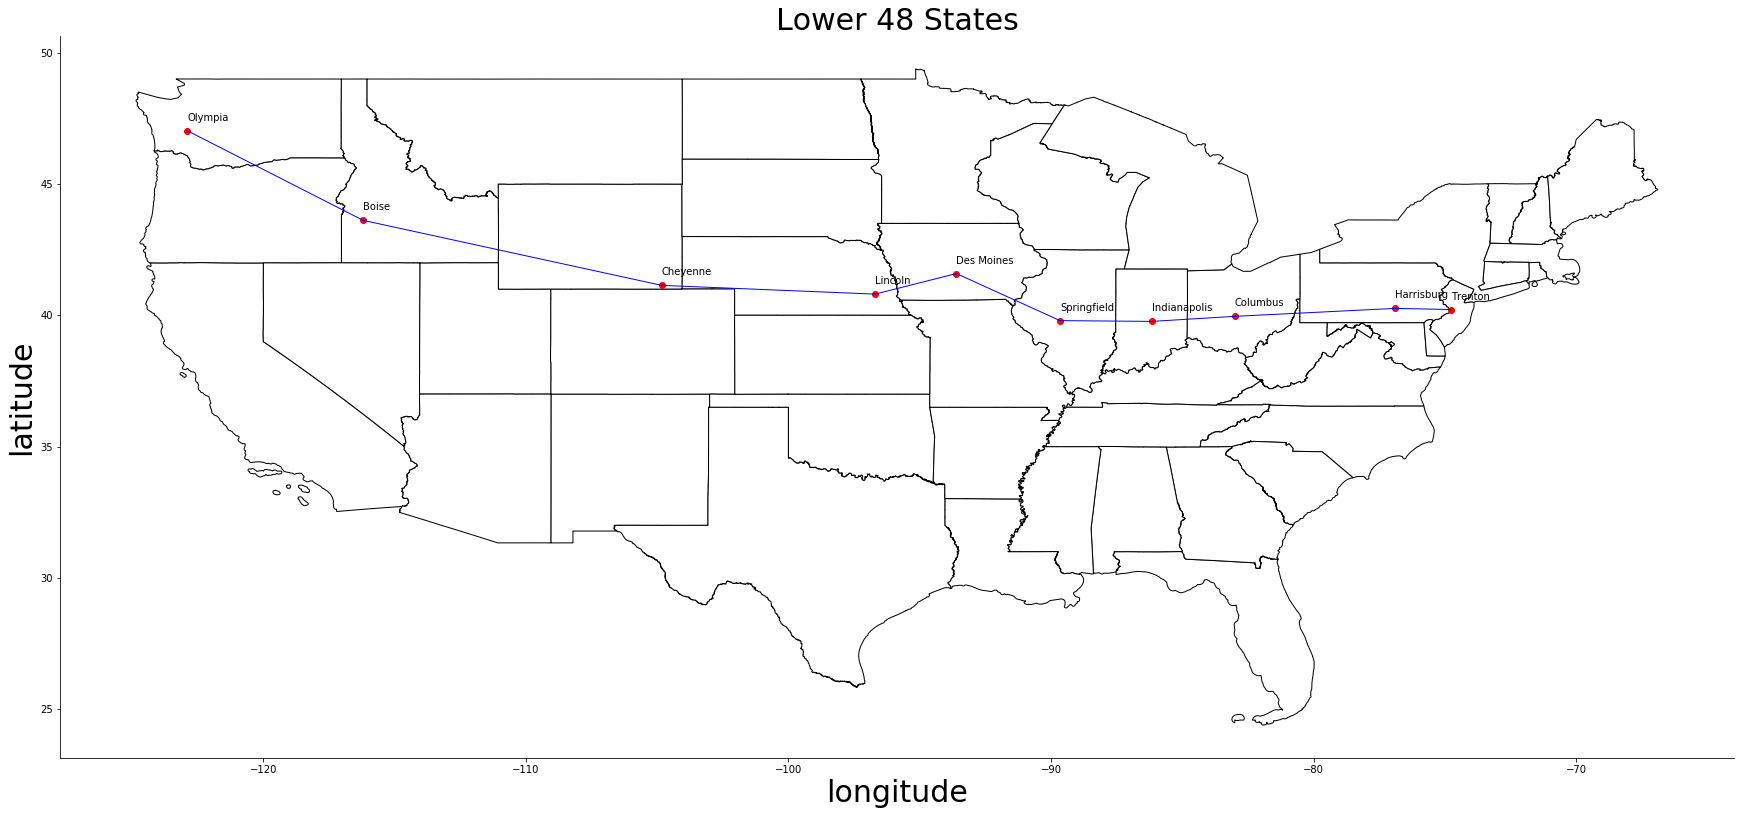

In [1037]:
#############
#Store user response and clean input 
#############
origin = str(input("Enter the origin state: "))
destination = str(input("Enter the destination state: ")) 
origin = origin.strip()
destination = destination.strip()

#############
#Run dijkstra function
#############
dijkstra(graph, origin, destination)

In total the Minimum Spanning Tree from each state capital in the lower 48 states is: 
 10754  miles.


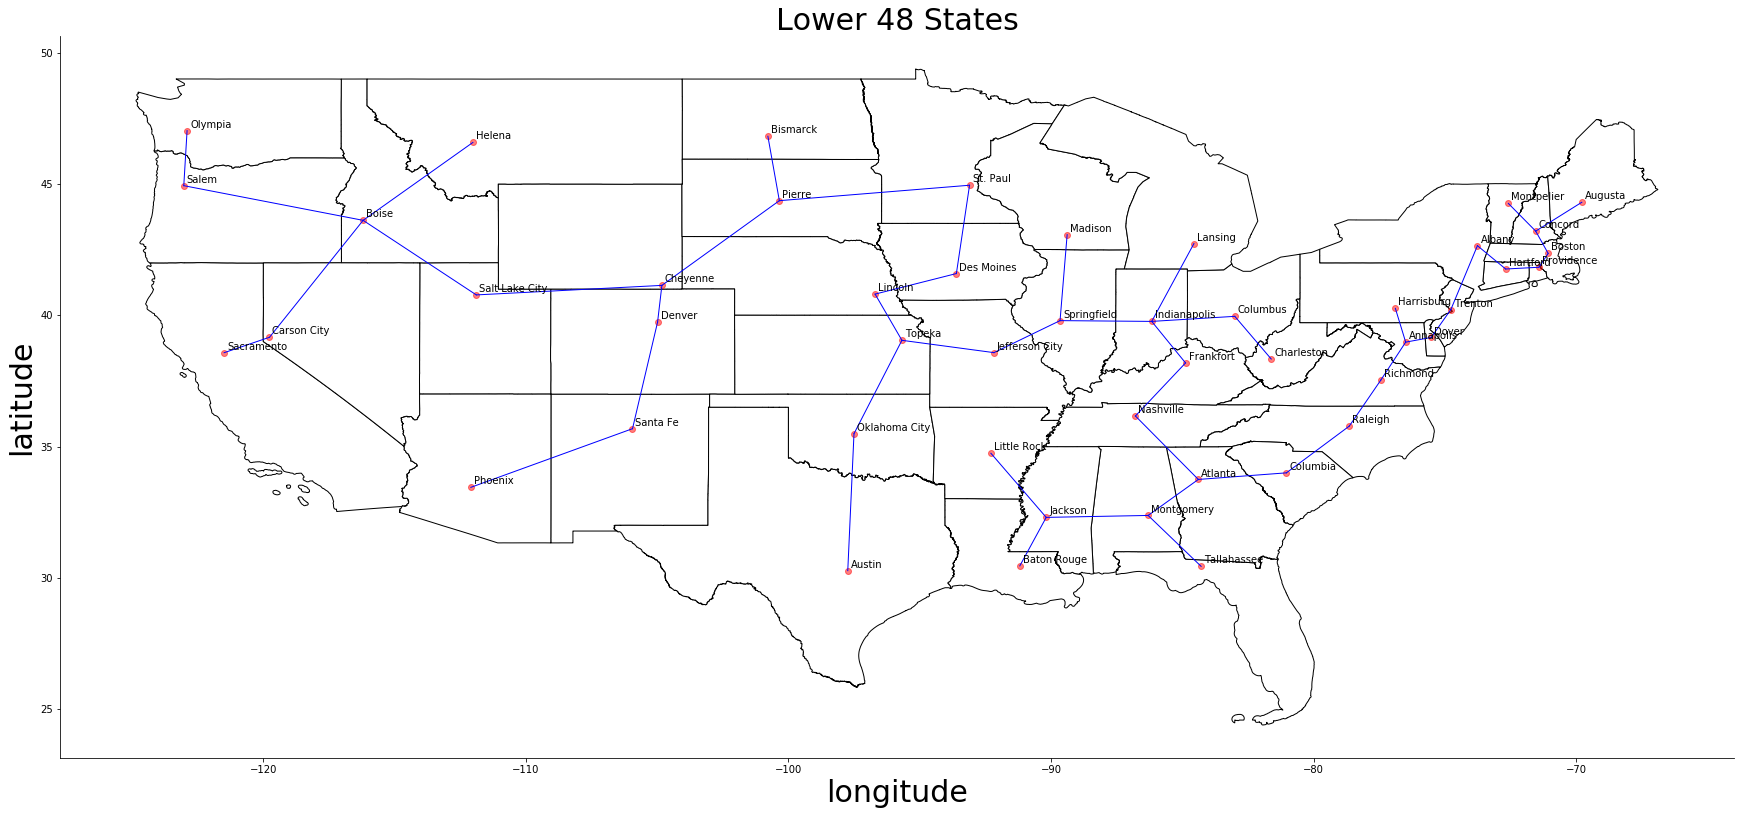

In [1033]:
#############
# Define functions 
# 1) Graph 
# sorts the graph in ascending order and other 
# 2) DisjointSet
# define vertices relationships in the graph 
# 3) kruskal 
# run kruskal algorithmn 
#############
class Graph:
    def __init__(self, vertices):
        self.vertices = vertices
        self.edges = []
    def add_edge(self, u, v, weight):
        self.edges.append((u, v, weight))
    def sort_edges(self):
        self.edges = sorted(self.edges, key=lambda item: item[2])
    def get_edges(self):
        return self.edges
    def number_of_vertices(self):
        return self.vertices

class DisjointSet:
    def __init__(self, size):
        self.parent = []
        self.rank = []
        for node in range(size):
            self.parent.append(node)
            self.rank.append(0)
    def find(self, v):
        if self.parent[v] == v:
            return v
        else:
            return self.find(self.parent[v])
    def union(self, u, v):
        u_root = self.find(u)
        v_root = self.find(v)
        if self.rank[u_root] < self.rank[v_root]:
            self.parent[u_root] = v_root
        elif self.rank[u_root] > self.rank[v_root]:
            self.parent[v_root] = u_root
        else:
            self.parent[v_root] = u_root
            self.rank[u_root] += 1

def kruskal(graph):
    forest = []
    graph.sort_edges()
    disjoint_set = DisjointSet(graph.number_of_vertices())
    for (u, v, weight) in graph.get_edges():
        if disjoint_set.find(u) != disjoint_set.find(v):
            forest.append((u, v, weight))
            disjoint_set.union(u, v)
    return forest



#############
# define the number of nodes in the graph  = g
# define the edges between the nodes vertex1 and vertex2 
#############
g = Graph(len(matrix_df))

for key in graph:
    for v,k in graph[key].items():
        vertex1 = int(state_df[state_df['State']==key].index.values)
        vertex2 = int(state_df[state_df['State']==v].index.values)
        #print(key,vertex1, v,vertex2 ,k) 
        g.add_edge(vertex1,vertex2,k)
result = kruskal(g)

#############
# loop through results of kruskal
# define counter, index (n), kruskal_df and other variables 
#############
n = 0
counter = 0
cols = ["Original Lat","Original Long","Destination Lat", "Destination Long"]
kruskal_df = pd.DataFrame(columns =cols)
for r in result:
    
    #############
    # store original state, destination state, distance 
    #############
    original_state = state_df.iat[r[0],0]
    destination_state = state_df.iat[r[1],0]
    distance = r[2]
    n += r[2]
    counter += 1
    
    #############
    # print the final total miles 
    #############
    if counter == len(result):
        print("In total the Minimum Spanning Tree from each state capital in the lower 48 states is: \n",n," miles.")
    
    #############
    # store os lat, long, ds lat, ds long
    #############
    original_state_lat = state_df.iat[r[0],3]
    original_state_long = state_df.iat[r[0],4]
    destination_state_lat = state_df.iat[r[1],3]
    destination_state_long = state_df.iat[r[1],4]
    
    #############
    #append to data frame 
    #############
    kruskal_df = kruskal_df.append(dict(zip(kruskal_df.columns,[original_state_lat, original_state_long, 
                                             destination_state_lat,destination_state_long])), ignore_index=True)


#############
# set us map that we defined earlier us48
#############
fig, gax = plt.subplots(figsize=(30,30))
us48.plot(ax=gax, edgecolor='black',color='white')

#############
# plot points, name labels, and configure map 
#############
gstate_df.plot(ax=gax, color='red', alpha = 0.5)
gax.set_xlabel('longitude', fontsize = 30)
gax.set_ylabel('latitude', fontsize = 30)
gax.set_title('Lower 48 States', fontsize = 30)
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

#############
# loop over points and add city name 
#############
for x, y, label in zip(gstate_df['Coordinates'].x, gstate_df['Coordinates'].y, gstate_df['Capital']):
    gax.annotate(label, xy=(x,y), xytext=(3,3), textcoords='offset points')

#############
# loop over points and add connecting edges 
#############
for olat,olong,dlat,dlong in zip(kruskal_df["Original Lat"],kruskal_df["Original Long"],kruskal_df["Destination Lat"],kruskal_df["Destination Long"]):
    plt.plot([olong , dlong], [olat, dlat], linewidth=1, color="blue", alpha=1)

plt.show()